In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import json
from geopy.geocoders import Nominatim
from tqdm import tqdm
from geopy.extra.rate_limiter import RateLimiter
from math import sqrt, pi
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN 
from sklearn.cluster import KMeans 

%matplotlib inline

In [73]:
df = pd.read_html("http://en.wikipedia.org/wiki/Planning_Areas_of_Singapore", flavor='html5lib', header=0)[2]
df.head()

#https://data.gov.sg/dataset/resident-working-persons-aged-15-years-over-by-planning-area-gross-monthly-income-from-work-2015

,Name (English),Malay,Chinese,Pinyin,Tamil,Region,Area (km2),Population[7],Density (/km2)
0,Ang Mo Kio,NaN,宏茂桥,Hóng mào qiáo,ஆங் மோ கியோ,North-East,13.94,163950,13400
1,Bedok,*,勿洛,Wù luò,பிடோக்,East,21.69,279380,13000
2,Bishan,NaN,碧山,Bì shān,பீஷான்,Central,7.62,88010,12000
3,Boon Lay,NaN,文礼,Wén lǐ,பூன் லே,West,8.23,30,3.6
4,Bukit Batok,*,武吉巴督,Wǔjí bā dū,புக்கிட் பாத்தோக்,West,11.13,153740,14000


In [74]:
df.drop(columns=["Malay", "Chinese", "Pinyin", "Tamil"], inplace = True)


In [76]:
df.replace('*',0,inplace=True)

In [77]:
df.dtypes

Name (English)     object
Region             object
Area (km2)        float64
Population[7]      object
Density (/km2)     object
dtype: object

In [78]:
df = df.astype({"Population[7]":"float64", "Density (/km2)":"float64"})

In [79]:
df.dtypes

Name (English)     object
Region             object
Area (km2)        float64
Population[7]     float64
Density (/km2)    float64
dtype: object

In [80]:
df.head()

,Name (English),Region,Area (km2),Population[7],Density (/km2)
0,Ang Mo Kio,North-East,13.94,163950.0,13400.0
1,Bedok,East,21.69,279380.0,13000.0
2,Bishan,Central,7.62,88010.0,12000.0
3,Boon Lay,West,8.23,30.0,3.6
4,Bukit Batok,West,11.13,153740.0,14000.0


In [10]:
# Initialising geocoding agent
geolocator = Nominatim(user_agent="Mozilla/76.0")
location = geolocator.geocode("Singapore")
latitude = location.latitude
longitude = location.longitude
print(f"Coordinates of Singapore are {latitude}, {longitude}")

Coordinates of Singapore are 1.357107, 103.8194992


In [11]:
!pip install geocoder
import geocoder
def get_latilong(name):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Singapore'.format(name))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('Ang Mo Kio')

[1.3716100000000324, 103.84546000000006]

In [12]:
# Retrieving Co-ordinates
names = df['Name (English)']    
coords = [ get_latilong(name) for name in names.tolist() ]

In [81]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [82]:
df.head()

,Name (English),Region,Area (km2),Population[7],Density (/km2),Latitude,Longitude
0,Ang Mo Kio,North-East,13.94,163950.0,13400.0,1.37161,103.84546
1,Bedok,East,21.69,279380.0,13000.0,1.32425,103.95297
2,Bishan,Central,7.62,88010.0,12000.0,1.35079,103.85110
3,Boon Lay,West,8.23,30.0,3.6,1.33333,103.70000
4,Bukit Batok,West,11.13,153740.0,14000.0,1.34952,103.75277


In [83]:
# Adding a new Search Radius column into dataframe, and re-ordering columns
# The new Search Radius will be used in the Foursquare API search query
df["Search Radius"] = df["Area (km2)"].apply(lambda x: round(sqrt(x/pi)*1000))
df = df[['Name (English)', 'Region', 'Area (km2)', 'Search Radius', 'Population[7]', 'Density (/km2)', 'Latitude', 'Longitude']]

In [18]:
!pip install folium
import folium
map_singapore = folium.Map(location = [latitude, longitude], zoom_start = 12)
for lat, lng, region, name in zip(df['Latitude'], df['Longitude'], df['Region'], df['Name (English)']):
    label = '{}, {}'.format(name, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)

map_singapore

     |████████████████████████████████| 94 kB 5.6 MB/s  eta 0:00:01


In [19]:
df.sort_values(by=['Population[7]'],ascending=False)

,Name (English),Region,Area (km2),Search Radius,Population[7],Density (/km2),Latitude,Longitude
1,Bedok,East,21.69,2628,279380.0,13000.00,1.324250,103.952970
17,Jurong West,West,14.69,2162,264860.0,18000.00,1.339490,103.707390
46,Tampines,East,20.89,2579,256730.0,12400.00,1.368190,103.929480
53,Woodlands,North,13.59,2080,254730.0,18700.00,1.435850,103.786980
39,Sengkang,North-East,10.59,1836,244600.0,23000.00,1.392440,103.894700
15,Hougang,North-East,13.93,2106,226240.0,16000.00,1.371240,103.891620
54,Yishun,North,21.24,2600,220320.0,10100.00,1.436210,103.835820
11,Choa Chu Kang,West,6.11,1395,190890.0,30000.00,1.386160,103.746180
33,Punggol,North-East,9.34,1724,170560.0,17800.00,1.402460,103.906860
0,Ang Mo Kio,North-East,13.94,2106,163950.0,13400.00,1.371610,103.845460


In [20]:
# Foursquare API
CLIENT_ID = 'VBHTBQQVDOLDD0S2MJOFLCA4K3B4AB1YFRXFUFNGTACQG1VM'  
CLIENT_SECRET = '4HYVQ2U1DQ2EH01EQ5WBMDXUVMBX2NAR0VNVFJM4WXD1QJKK' 
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: Hidden')
print('CLIENT_SECRET: Hidden')

Your credentails:
CLIENT_ID: Hidden
CLIENT_SECRET: Hidden


In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
sg_venues = getNearbyVenues(names=df['Name (English)'], latitudes=df['Latitude'],longitudes=df['Longitude'], radius = df['Search Radius'])

Ang Mo Kio
Bedok
Bishan
Boon Lay
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Central Water Catchment
Changi
Changi Bay
Choa Chu Kang
Clementi
Downtown Core
Geylang
Hougang
Jurong East
Jurong West
Kallang
Lim Chu Kang
Mandai
Marina East
Marina South
Marine Parade
Museum
Newton
North-Eastern Islands
Novena
Orchard
Outram
Pasir Ris
Paya Lebar
Pioneer
Punggol
Queenstown
River Valley
Rochor
Seletar
Sembawang
Sengkang
Serangoon
Simpang
Singapore River
Southern Islands
Straits View
Sungei Kadut
Tampines
Tanglin
Tengah
Toa Payoh
Tuas
Western Islands
Western Water Catchment
Woodlands
Yishun


In [36]:
sg_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ang Mo Kio,30,30,30,30,30,30
Bedok,30,30,30,30,30,30
Bishan,30,30,30,30,30,30
Boon Lay,30,30,30,30,30,30
Bukit Batok,30,30,30,30,30,30
Bukit Merah,30,30,30,30,30,30
Bukit Panjang,30,30,30,30,30,30
Bukit Timah,30,30,30,30,30,30
Central Water Catchment,30,30,30,30,30,30


In [23]:
# Check out the activities available around 
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")
sg_onehot['Neighborhood'] = sg_venues['Neighborhood'] 

fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]
sg_onehot.head()

,Neighborhood,Accessories Store,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Aquarium,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Dropping duplicated venues from the dataframe
sg_venues2 = sg_venues.drop_duplicates(subset='Venue')
print('Number of duplicated venues removed {}'.format(sg_venues.shape[0]-sg_venues2.shape[0]))

Number of duplicated venues removed 385


In [25]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_venues2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sg_onehot.insert(loc = 0, column = 'Neighborhood', value = sg_venues2['Neighborhood'])

# summing one-hot values
sg_grouped_sum = sg_onehot.groupby('Neighborhood').sum().reset_index()
sg_grouped_sum.head()

,Neighborhood,Accessories Store,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Aquarium,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bedok,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bishan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Boon Lay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,Bukit Batok,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
num_top_venues = 5
for neigh in sg_grouped_sum['Neighborhood']:
    print("----"+neigh+"----")
    temp = sg_grouped_sum[sg_grouped_sum['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ang Mo Kio----
                venue  freq
0                Park   3.0
1  Chinese Restaurant   3.0
2         Supermarket   2.0
3        Noodle House   2.0
4  Miscellaneous Shop   1.0


----Bedok----
                venue  freq
0          Food Court   4.0
1                Café   3.0
2        Dessert Shop   3.0
3         Coffee Shop   2.0
4  Seafood Restaurant   2.0


----Bishan----
                 venue  freq
0   Chinese Restaurant   4.0
1           Food Court   3.0
2               Bakery   2.0
3       Ice Cream Shop   2.0
4  Japanese Restaurant   1.0


----Boon Lay----
                  venue  freq
0  Fast Food Restaurant   3.0
1   Japanese Restaurant   2.0
2  Gym / Fitness Center   2.0
3           Coffee Shop   2.0
4    Chinese Restaurant   2.0


----Bukit Batok----
                           venue  freq
0                     Food Court   5.0
1             Chinese Restaurant   4.0
2  Vegetarian / Vegan Restaurant   2.0
3                    Coffee Shop   2.0
4              Accesso

In [27]:
# Getting the top 10 venue categories in all Planning Areas combined
venue_count = sg_venues2[['Neighborhood', 'Venue Category']].groupby('Venue Category').count()
venue_top10 = venue_count.sort_values(by='Neighborhood', ascending=False).rename(columns={'Neighborhood':'Count'}).head(10)
venue_top10.reset_index(drop=False, inplace=True)
venue_top10

,Venue Category,Count
0,Chinese Restaurant,69
1,Food Court,49
2,Park,42
3,Café,40
4,Coffee Shop,38
5,Hotel,33
6,Asian Restaurant,30
7,Japanese Restaurant,28
8,Bakery,24
9,Seafood Restaurant,23


In [28]:
# Calculating pearson correlations of all venue categories with density
correlation = sg_grouped_sum.corrwith(df["Density (/km2)"], method='pearson')
correlation.sort_values(ascending=False, inplace=True)
print(f'Pearson correlation of top 5 venue categories with population density: \n{correlation[:5]} \n')
print(f'Pearson correlation of bottom 5 venue categories with population density: \n{correlation[-5:]}')

Pearson correlation of top 5 venue categories with population density: 
Noodle House             0.448204
Portuguese Restaurant    0.444195
Stadium                  0.358885
Kids Store               0.311143
Pool                     0.306756
dtype: float64 

Pearson correlation of bottom 5 venue categories with population density: 
Event Space   -0.179932
Exhibit       -0.191916
Art Gallery   -0.198738
Hotel         -0.212291
Waterfront    -0.252655
dtype: float64


In [113]:
# Filtering the variable of interest for further analysis
vegan = sg_grouped_sum[['Neighborhood', 'Vegetarian / Vegan Restaurant']]
vegan.insert(loc=1, column='Density (/km2)', value=df['Density (/km2)'])
vegan.rename(columns={'Vegetarian / Vegan Restaurant':'Count'}, inplace=True)
Total = vegan['Count'].sum()
print (Total)
print(vegan.sort_values(by="Count",ascending=False)[['Neighborhood','Count']].head())

12
   Neighborhood  Count
35       Rochor      4
30   Paya Lebar      2
4   Bukit Batok      2
15      Hougang      1
39    Serangoon      1


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


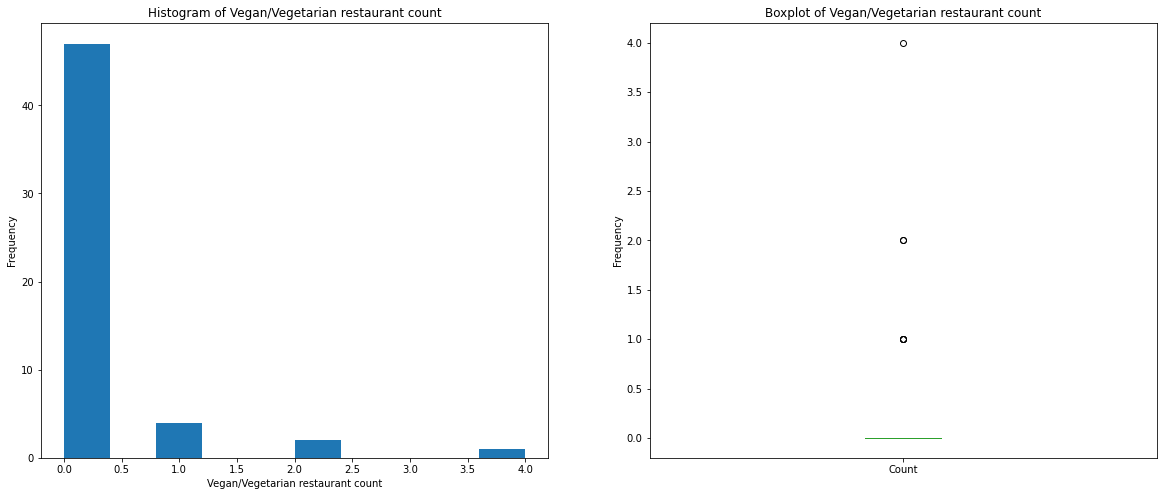

In [30]:
# Visualising the distribution of Vegan/Vegetarian restaurant count
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

# Subplot 1: Histogram
vegan['Count'].plot(kind='hist', title='Histogram of Vegan/Vegetarian restaurant count', figsize=(20,8), ax=ax0)
ax0.set_xlabel('Vegan/Vegetarian restaurant count')

# Subplot 2: Boxplot
vegan['Count'].plot(kind='box', title='Boxplot of Vegan/Vegetarian restaurant count', figsize=(20,8), ax=ax1)
ax1.set_ylabel('Frequency')

plt.show()

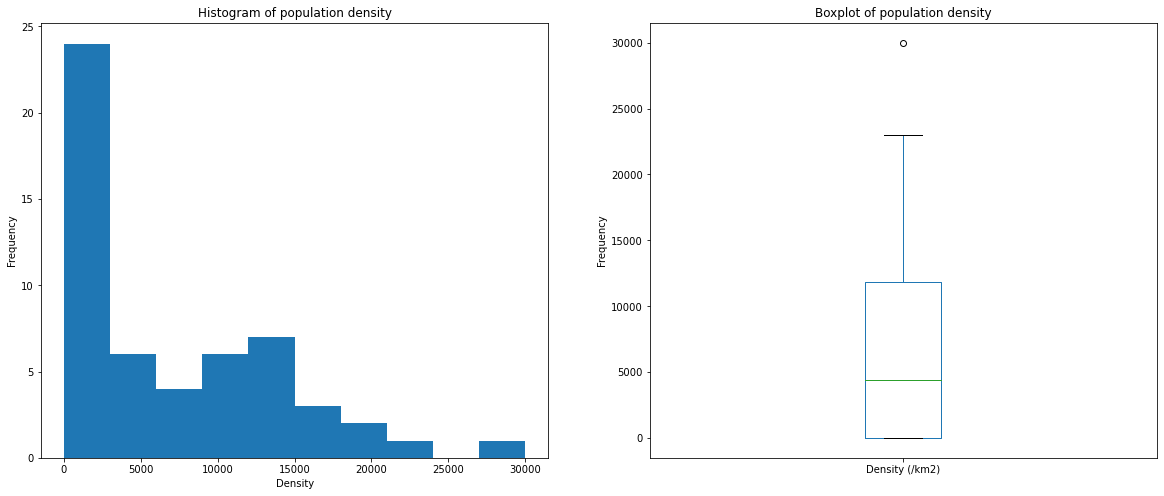

In [31]:
# Visualising the distribution of Density
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

# Subplot 1: Histogram
vegan['Density (/km2)'].plot(kind='hist', title='Histogram of population density', figsize=(20, 8), ax=ax0)
ax0.set_xlabel('Density')

# Subplot 2: Boxplot
vegan['Density (/km2)'].plot(kind='box', title='Boxplot of population density', figsize=(20,8), ax=ax1)
ax1.set_ylabel('Frequency')

plt.show()

In [32]:
# Data Standardisation
scaler = StandardScaler()
vegan_scaled = scaler.fit_transform(vegan[['Density (/km2)', 'Count']])
vegan_scaled_df = pd.DataFrame(vegan_scaled, columns=['Density_norm', 'Count_norm'])

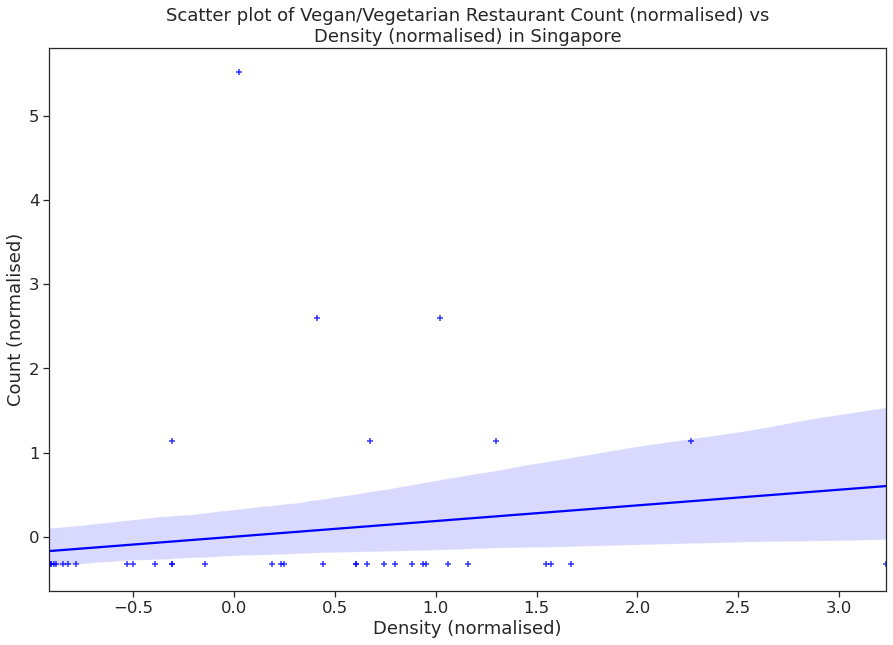

In [33]:
# Plotting scatter plot between Vegan/Vegetarian Restaurant count and Density
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
sns.set_style('ticks')
sns.regplot(x='Density_norm', y='Count_norm', data=vegan_scaled_df, color='blue', marker='+')
plt.xlabel('Density (normalised)')
plt.ylabel('Count (normalised)')
plt.title('Scatter plot of Vegan/Vegetarian Restaurant Count (normalised) vs\nDensity (normalised) in Singapore')
plt.show()

In [54]:
# run k-means clustering
k_means = KMeans(n_clusters=3, random_state=0, n_init=12).fit(vegan_scaled)

# saving the labels and cluster centers into variables
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

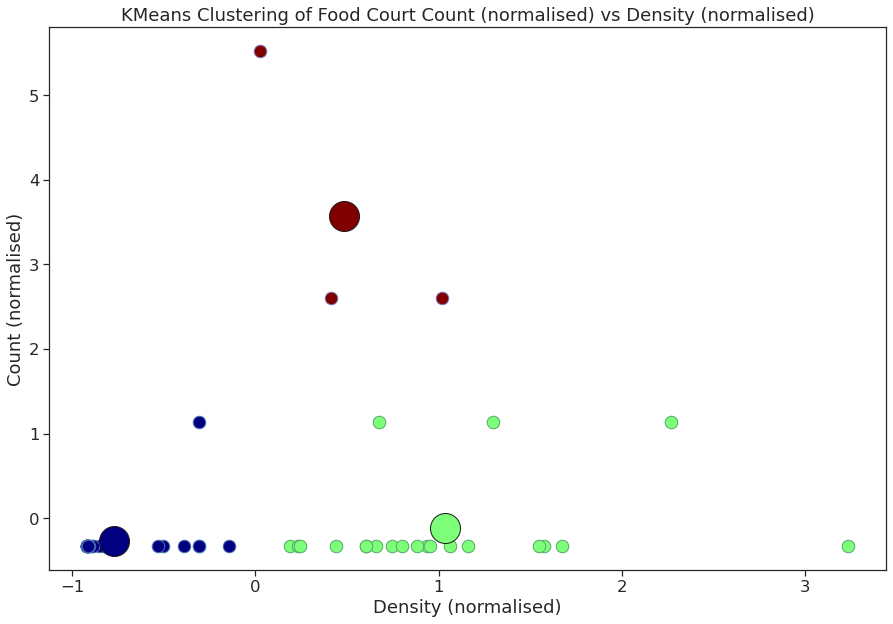

In [55]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(15,10))

# Colours uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colours = plt.cm.jet(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# Setting font size
plt.rcParams.update({'font.size': 14})

# For loop that plots the data points and centroids.
for k, col in zip(range(len(k_means_cluster_centers)), colours):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(vegan_scaled[my_members, 0], vegan_scaled[my_members, 1], 'o', markerfacecolor=col, marker='.', markersize=25)
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=30)

ax.set_title('KMeans Clustering of Food Court Count (normalised) vs Density (normalised)')
ax.set_xlabel('Density (normalised)')
ax.set_ylabel('Count (normalised)')
plt.show()

In [85]:
df.rename(columns = {'Name (English)': 'Neighborhood'}, inplace = True)

In [88]:
# Creating a new dataframe with necessary columns and adding cluster labels generated from K-Means algorithm
vegan_merged = pd.merge(vegan, 
                     df[['Neighborhood', 'Latitude', 'Longitude']], 
                     how='left',
                     on = 'Neighborhood')
vegan_merged.insert(loc=(len(vegan_merged.columns)), column='Cluster Label', value=k_means_labels)
vegan_merged.head()

,Neighborhood,Density (/km2),Count,Latitude,Longitude,Cluster Label
0,Ang Mo Kio,13400.0,0,1.37161,103.84546,1
1,Bedok,13000.0,0,1.32425,103.95297,1
2,Bishan,12000.0,0,1.35079,103.85110,1
3,Boon Lay,3.6,0,1.33333,103.70000,0
4,Bukit Batok,14000.0,2,1.34952,103.75277,2


In [90]:
# Summary of cluster labels
vegan_merged['Cluster Label'].value_counts()

0    30
1    21
2     3
Name: Cluster Label, dtype: int64

In [94]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
db = DBSCAN(eps=0.35, min_samples=3).fit(vegan_scaled)
labels = db.labels_
# set color scheme for the clusters
x = np.arange(len(set(labels)))
ys = [i + x + (i*x)**2 for i in range(len(set(labels)))]
colors_array = cm.jet(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vegan_merged['Latitude'], vegan_merged['Longitude'], vegan_merged['Neighborhood'], \
                                  vegan_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

In [101]:
cluster0 = vegan_merged[vegan_merged['Cluster Label'] == 2].drop(columns=['Latitude', 'Longitude'])

In [102]:
print('Cluster 0 (n={}) are areas with high numbers of Vegan/Vegetarian restaurants per Neighborhood (range: {} - {})\n\
with moderate Population Denisty (median density={})'.format(cluster0.count()[0], 
                                                           cluster0['Count'].min(),
                                                           cluster0['Count'].max(),
                                                           cluster0['Density (/km2)'].median()))
cluster0.sort_values(by='Count', ascending=False)

Cluster 0 (n=3) are areas with high numbers of Vegan/Vegetarian restaurants per Neighborhood (range: 2 - 4)
with moderate Population Denisty (median density=9600.0)


,Neighborhood,Density (/km2),Count,Cluster Label
35,Rochor,6800.0,4,2
4,Bukit Batok,14000.0,2,2
30,Paya Lebar,9600.0,2,2


In [110]:
cluster1 = vegan_merged[vegan_merged['Cluster Label'] == 1].drop(columns=['Latitude', 'Longitude'])
print('Cluster 1 (n={}) are areas with high numbers of Vegan/Vegetarian restaurants per Neighborhood (range: {} - {})\n\
with moderate Population Denisty (median density={})'.format(cluster1.count()[0], 
                                                           cluster1['Count'].min(),
                                                           cluster1['Count'].max(),
                                                           cluster1['Density (/km2)'].median()))
cluster1.sort_values(by='Count', ascending=False)

Cluster 1 (n=21) are areas with high numbers of Vegan/Vegetarian restaurants per Neighborhood (range: 0 - 1)
with moderate Population Denisty (median density=13000.0)


,Neighborhood,Density (/km2),Count,Cluster Label
40,Simpang,11500.0,1,1
39,Serangoon,23000.0,1,1
15,Hougang,16000.0,1,1
0,Ang Mo Kio,13400.0,0,1
23,Marine Parade,8000.0,0,1
49,Tuas,14300.0,0,1
46,Tanglin,12400.0,0,1
38,Sengkang,8400.0,0,1
36,Seletar,8300.0,0,1
33,Queenstown,17800.0,0,1


In [111]:
cluster2 = vegan_merged[vegan_merged['Cluster Label'] == 0].drop(columns=['Latitude', 'Longitude'])
print('Cluster 2 (n={}) are areas with high numbers of Vegan/Vegetarian restaurants per Neighborhood (range: {} - {})\n\
with moderate Population Denisty (median density={})'.format(cluster2.count()[0], 
                                                           cluster2['Count'].min(),
                                                           cluster2['Count'].max(),
                                                           cluster2['Density (/km2)'].median()))
cluster2.sort_values(by='Count', ascending=False)

Cluster 2 (n=30) are areas with high numbers of Vegan/Vegetarian restaurants per Neighborhood (range: 0 - 1)
with moderate Population Denisty (median density=19.65)


,Neighborhood,Density (/km2),Count,Cluster Label
16,Jurong East,4400.00,1,0
3,Boon Lay,3.60,0,0
31,Pioneer,3.40,0,0
51,Western Water Catchment,0.25,0,0
50,Western Islands,2.30,0,0
48,Toa Payoh,1.40,0,0
47,Tengah,2800.00,0,0
45,Tampines,53.20,0,0
44,Sungei Kadut,0.00,0,0
43,Straits View,244.00,0,0
